In [1]:
# imports
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torch, os, torchvision
from torchvision import datasets, models, transforms
from pathlib import Path



from utils import display_images, imshow, train_model, plot_cf
ProjectRoot = Path().cwd().parent
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Food Recognition

# Data

- Images of white rice and non white rice items has been download from Google Images using [Download All Images](https://add0n.com/save-images.html) chrome extension
- For non white rice images following dishes has been used
    - Dosa
    - Idli
    - Chapati
    
- 70% of white rice images has been used in training and 30% for testing
- 70% of samples from Dosa, Idli and Chapati has been used in training and 30% fo testing

## Data distribution

Class samples distribution in train:{'not_white_rice': 121, 'white_rice': 130}
Class samples distribution in test:{'not_white_rice': 107, 'white_rice': 116}



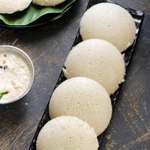
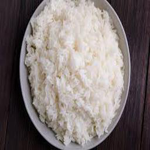
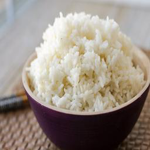
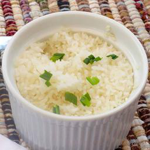
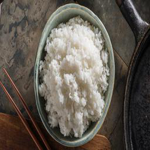
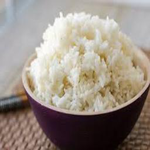
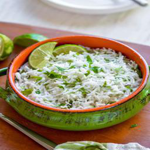
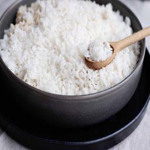
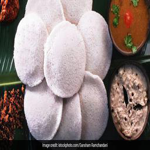
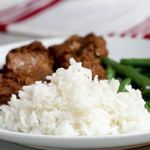
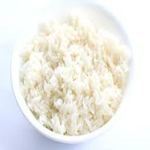
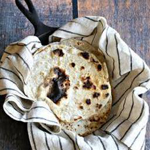
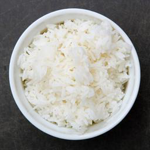
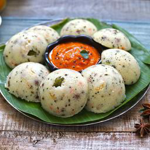
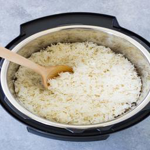
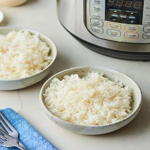
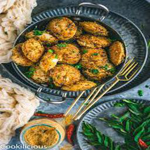
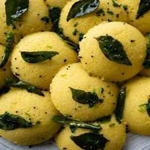
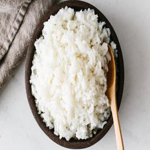
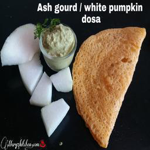


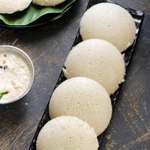
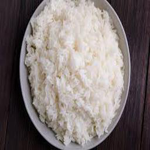
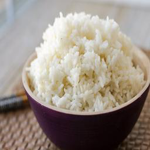
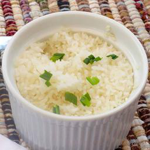
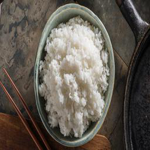
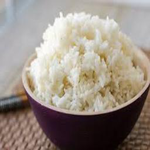
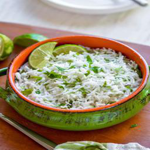
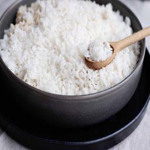
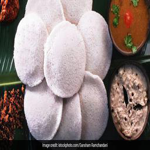
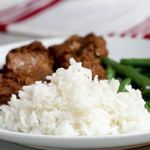
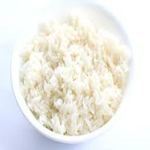
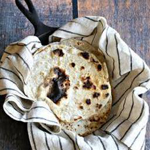
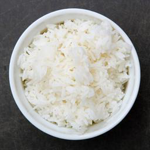
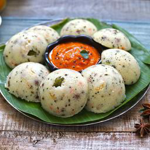
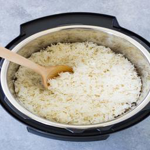
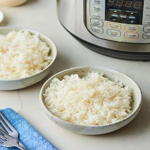
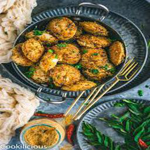
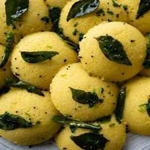
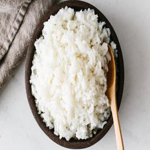
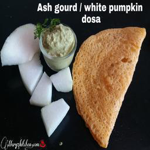

In [2]:
# sample view of images
display_images()

# Model

- Identifying whether white rice is in a image or not is a classical Image classification problem
- Pre-trained ResNet18 on ImageNet has been fine tuned using transfer learning to perform this classification task

In [3]:
# defin pretrained resnet18 model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
# push model to GPU
model = model.to(device)
# define loss function
criterion = nn.CrossEntropyLoss()
# define optimiser
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train

## Data Augmentations

In [4]:
# train and test augmentations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# create pytorch datasets
data_dir = str(ProjectRoot/'data')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# create pytorch dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Train

In [5]:
trained_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=25, save_dir=ProjectRoot/'models')

Epoch 0/24
----------
train Loss: 0.5498 Acc: 0.7171
test Loss: 0.2255 Acc: 0.9731

Epoch 1/24
----------
train Loss: 0.1721 Acc: 0.9681
test Loss: 0.0677 Acc: 0.9910

Epoch 2/24
----------
train Loss: 0.1041 Acc: 0.9602
test Loss: 0.0297 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.1473 Acc: 0.9482
test Loss: 0.0242 Acc: 0.9955

Epoch 4/24
----------
train Loss: 0.0500 Acc: 0.9920
test Loss: 0.0101 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0215 Acc: 1.0000
test Loss: 0.0071 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0170 Acc: 0.9960
test Loss: 0.0048 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0155 Acc: 1.0000
test Loss: 0.0052 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0347 Acc: 0.9920
test Loss: 0.0046 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0113 Acc: 1.0000
test Loss: 0.0046 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0460 Acc: 0.9920
test Loss: 0.0042 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0199 Acc: 1.0000
test Loss: 0.0042 Acc

# Evaluate

In [6]:
from IPython.display import Image as IImage
from IPython.display import display
from PIL import Image
from pprint import pprint
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

# set model to eval model
model.eval()
classes = ['not_white_rice', 'white_rice']
y_true, y_pred = [], []
for img_pth in Path('/home/satish27may/Foodie/data/test').glob('*/*'):
    image = Image.open(img_pth)
    test_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze(0)

    
    output = model(image_tensor.cuda())
    pred_cls = classes[output.data.cpu().numpy().argmax()]
    y_pred.append(pred_cls)
    y_true.append(img_pth.parent.name)
    if img_pth.parent.name!=pred_cls:
        display(IImage(filename=str(img_pth)))
        print(pred_cls, np.max(torch.softmax(output,dim=1).data.cpu().numpy()), img_pth.parent.name)


In [7]:
# classification report
print(classification_report(y_true, y_pred, labels=classes))

                precision    recall  f1-score   support

not_white_rice       1.00      1.00      1.00       107
    white_rice       1.00      1.00      1.00       116

      accuracy                           1.00       223
     macro avg       1.00      1.00      1.00       223
  weighted avg       1.00      1.00      1.00       223



[[1. 0.]
 [0. 1.]]


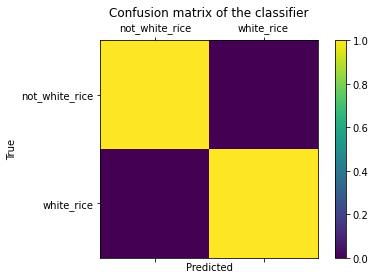

In [8]:
# confusion matrix
plot_cf(y_true, y_pred, class_names)